In [1]:
import bz2
import os
import os.path as osp
import sys

import cv2
import dlib
import numpy as np
import requests
import scipy.ndimage
from PIL import Image
from tqdm import tqdm

LANDMARKS_MODEL_URL = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"

In [2]:
class LandmarksDetector:
    def __init__(self, predictor_model_path):
        """
        :param predictor_model_path: path to shape_predictor_68_face_landmarks.dat file
        """
        self.detector = (
            dlib.get_frontal_face_detector()
        )  # cnn_face_detection_model_v1 also can be used
        self.shape_predictor = dlib.shape_predictor(predictor_model_path)

    def get_landmarks(self, image):
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dets = self.detector(img, 1)

        for detection in dets:
            face_landmarks = [
                (item.x, item.y)
                for item in self.shape_predictor(img, detection).parts()
            ]
            return face_landmarks


def unpack_bz2(src_path):
    dst_path = src_path[:-4]
    if os.path.exists(dst_path):
        print("cached")
        return dst_path
    data = bz2.BZ2File(src_path).read()
    with open(dst_path, "wb") as fp:
        fp.write(data)
    return dst_path


def work_landmark(raw_img_path, img_name, face_landmarks):
    face_img_name = "%s.jpg" % (os.path.splitext(img_name)[0],)
    aligned_face_path = os.path.join(ALIGNED_IMAGES_DIR, face_img_name)
    if os.path.exists(aligned_face_path):
        return
    image_align(raw_img_path, aligned_face_path, face_landmarks, output_size=256)


def get_file(src, tgt):
    if os.path.exists(tgt):
        print("cached")
        return tgt
    tgt_dir = os.path.dirname(tgt)
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    file = requests.get(src)
    open(tgt, "wb").write(file.content)
    return tgt

In [3]:
landmarks_model_path = unpack_bz2(
    get_file(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "temp/shape_predictor_68_face_landmarks.dat.bz2",
    )
)

cached
cached


In [4]:
img_dir = "videos/video1_frames_align/"
dir_list = sorted(os.listdir(img_dir))

## 選択

In [5]:
IMAGES = []
LANDMARKS = []
for i in range(len(dir_list)):
    img_path = img_dir + dir_list[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    IMAGES.append(img)
    landmarks_detector = LandmarksDetector(landmarks_model_path)
    landmark = landmarks_detector.get_landmarks(img_path)
    LANDMARKS.append(landmark)

In [6]:
lm = np.array(LANDMARKS)
lm_eyebrow_left = lm[:, 17:22]  # left-right
lm_eyebrow_right = lm[:, 22:27]  # left-right
lm_nose = lm[:, 27:31]  # top-down
lm_nostrils = lm[:, 31:36]  # top-down
lm_eye_left = lm[:, 36:42]  # left-clockwise
lm_eye_right = lm[:, 42:48]  # left-clockwise
lm_mouth_outer = lm[:, 48:60]  # left-clockwise
lm_mouth_inner = lm[:, 60:68]  # left-clockwise

## all

In [85]:
IMAGES_ALL_CROP = []
IMAGES_ALL_LESS = []
for i in range(len(IMAGES)):
    img_all = IMAGES[i].copy()
    pt_all = np.concatenate([lm[i, :17], np.flipud(lm[i, 17:27])])
    pt_all_center = pt_all.sum(axis=0) // len(pt_all)
    for j in range(17):
        if pt_all[j][0] < pt_all_center[0]:
            pt_all[j][0] += 3
        else:
            pt_all[j][0] -= 3
    
        if pt_all[j][1] < pt_all_center[1]:
            pt_all[j][1] += 3
        else:
            pt_all[j][1] -= 3
    
    for j in range(17, 27):
        pt_all[j][1] -= 8

    mask_all = np.zeros(IMAGES[i].shape, IMAGES[i].dtype)
    cv2.fillPoly(mask_all, [pt_all], (255, 255, 255))
    IMAGES_ALL_CROP.append(mask)
    all_less = cv2.illuminationChange(IMAGES[i], mask_all, alpha=2, beta=2)
    IMAGES_ALL_LESS.append(all_less)

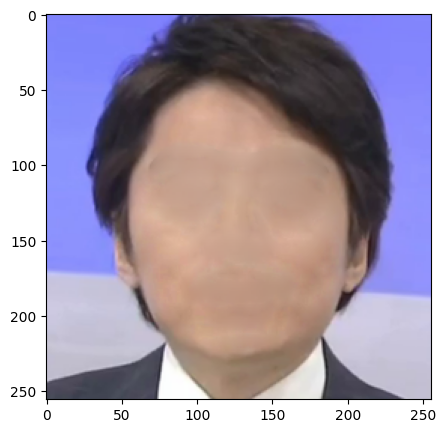

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(IMAGES_ALL_LESS[0])
plt.show()

## eye

In [43]:
mask_eye = None
for i in range(len(IMAGES)):   
    img_eye = IMAGES[i].copy()
    pt_eye_left = np.vstack([lm[i, 17:22], lm[i, 39:42], lm[i, 36]])
    pt_eye_right = np.vstack([lm[i, 22:27], lm[i, 45:48], lm[i, 42]])
    pt_eye_left_center = pt_eye_left.sum(axis=0) // len(pt_eye_left)
    for j in range(len(pt_eye_left)):
        if pt_eye_left[j][0] < pt_eye_left_center[0]:
            pt_eye_left[j][0] -= 5
        else:
            pt_eye_left[j][0] += 5
    
        if pt_eye_left[j][1] < pt_eye_left_center[1]:
            pt_eye_left[j][1] -= 5
        else:
            pt_eye_left[j][1] += 10
    
    pt_eye_right_center = pt_eye_right.sum(axis=0) // len(pt_eye_right)
    for j in range(len(pt_eye_right)):
        if pt_eye_right[j][0] < pt_eye_right_center[0]:
            pt_eye_right[j][0] -= 5
        else:
            pt_eye_right[j][0] += 5
    
        if pt_eye_right[j][1] < pt_eye_right_center[1]:
            pt_eye_right[j][1] -= 5
        else:
            pt_eye_right[j][1] += 10

    pt_eye2 = np.vstack([
        pt_eye_left[:5],
        pt_eye_right,
        pt_eye_left[5:]
    ])

    mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
    cv2.fillPoly(mask, [pt_eye2], (255, 255, 255))
    if i == 0:
        mask_eye = mask
    else:
        mask_eye = mask_eye | mask

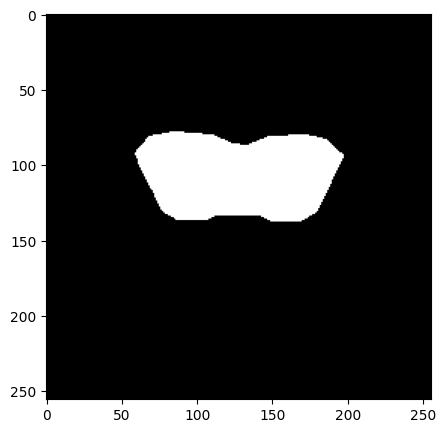

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(mask_eye)
plt.show()

In [45]:
IMAGES_EYE_CROP = []
for i in range(len(IMAGES)):
    crop_eye = np.zeros(IMAGES[i].shape, IMAGES[i].dtype)
    crop_eye = cv2.bitwise_and(IMAGES[i], mask_eye)
    IMAGES_EYE_CROP.append(crop_eye)

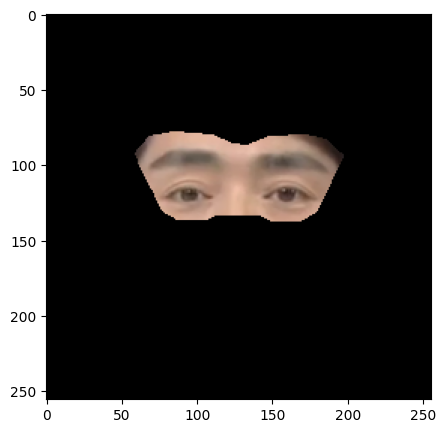

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(IMAGES_EYE_CROP[0])
plt.show()

In [47]:
IMAGES_EYE_LESS = []
for i in range(len(IMAGES)):  
    eye_less = cv2.illuminationChange(IMAGES[i], mask_eye, alpha=2, beta=2)
    IMAGES_EYE_LESS.append(eye_less)

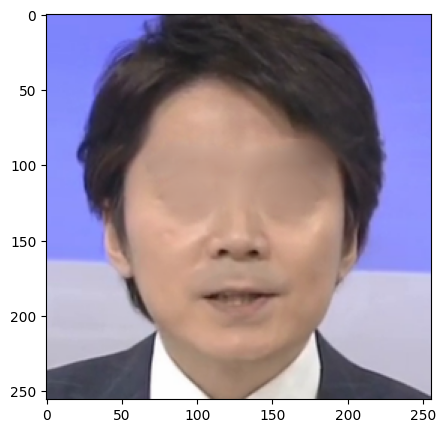

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(IMAGES_EYE_LESS[200])
plt.show()

## mouth

In [51]:
mask_mouth = None
for i in range(len(IMAGES)):
    img_mouth = IMAGES[i].copy()
    pt_mouth = lm[i, 48:60].copy()

    pt_mouth_center = pt_mouth.sum(axis=0) // len(pt_mouth)
    for j in range(len(pt_mouth)):
        if pt_mouth[j][0] < pt_mouth_center[0]:
            pt_mouth[j][0] -= 15
        else:
            pt_mouth[j][0] += 15
    
        if pt_mouth[j][1] < pt_mouth_center[1]:
            pt_mouth[j][1] -= 10
        else:
            pt_mouth[j][1] += 10

    mask = np.zeros(IMAGES[i].shape, IMAGES[i].dtype)
    cv2.fillPoly(mask, [pt_mouth], (255, 255, 255))
    if i == 0:
        mask_mouth = mask
    else:
        mask = mask_mouth | mask

In [52]:
IMAGES_MOUTH_CROP = []
for i in range(len(IMAGES)):
    crop_mouth = np.zeros(IMAGES[i].shape, IMAGES[i].dtype)
    crop_mouth = cv2.bitwise_and(IMAGES[i], mask_mouth)
    IMAGES_MOUTH_CROP.append(crop_mouth)

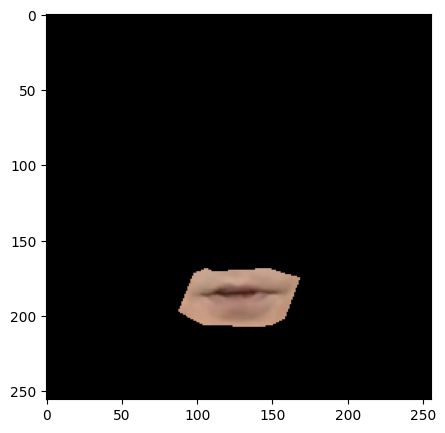

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(IMAGES_MOUTH_CROP[0])
plt.show()

In [54]:
IMAGES_MOUTH_LESS = []
for i in range(len(IMAGES)):  
    mouth_less = cv2.illuminationChange(IMAGES[i], mask_mouth, alpha=2, beta=2)
    IMAGES_MOUTH_LESS.append(mouth_less)

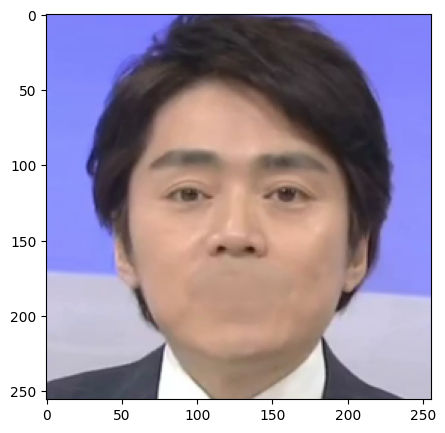

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(IMAGES_MOUTH_LESS[0])
plt.show()

## eye&mouth

eye, mouthを実行してから

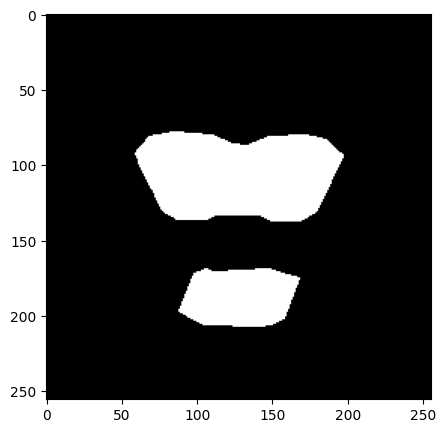

In [56]:
mask_eye_mouth = mask_eye | mask_mouth
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(mask_eye_mouth)
plt.show()

In [57]:
IMAGES_EYE_MOUTH_CROP = []
for i in range(len(IMAGES)):
    crop_eye_mouth = np.zeros(IMAGES[i].shape, IMAGES[i].dtype)
    crop_eye_mouth = cv2.bitwise_and(IMAGES[i], mask_eye_mouth)
    IMAGES_EYE_MOUTH_CROP.append(crop_eye_mouth)

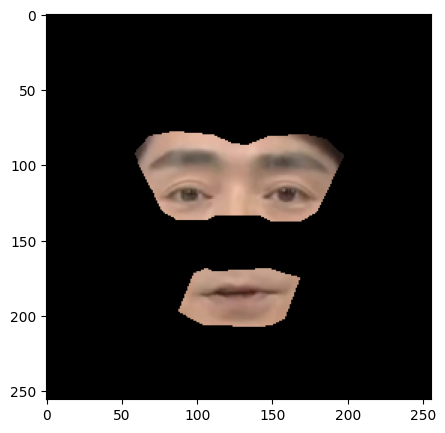

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(IMAGES_EYE_MOUTH_CROP[0])
plt.show()

In [59]:
IMAGES_EYE_MOUTH_LESS = []
for i in range(len(IMAGES)):  
    eye_mouth_less = cv2.illuminationChange(IMAGES[i], mask_eye_mouth, alpha=2, beta=2)
    IMAGES_EYE_MOUTH_LESS.append(eye_mouth_less)

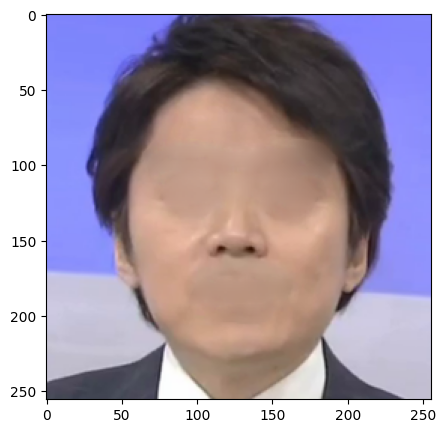

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(IMAGES_EYE_MOUTH_LESS[0])
plt.show()

## 合成

### eye

In [62]:
IMAGES_EYE_SYN = []
for i in range(len(IMAGES)):
    if i == 0:
        IMAGES_EYE_SYN.append(IMAGES[0])
        continue
    monoMaskImage = cv2.split(mask_eye)[0] # reducing the mask to a monochrome
    br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
    center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
    eye_syn = cv2.seamlessClone(IMAGES[i], IMAGES_EYE_LESS[0], mask_eye, center, cv2.NORMAL_CLONE)
    IMAGES_EYE_SYN.append(eye_syn)

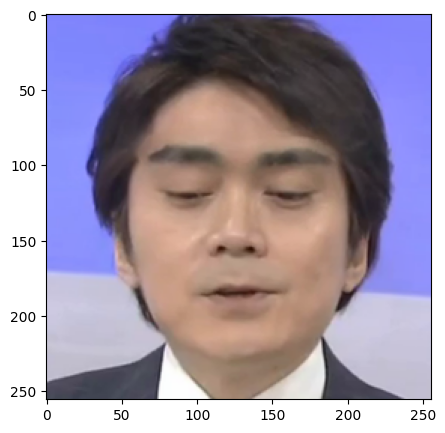

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(IMAGES_EYE_SYN[250])
plt.show()

### mouth

In [68]:
IMAGES_MOUTH_SYN = []
for i in range(len(IMAGES)):
    if i == 0:
        IMAGES_MOUTH_SYN.append(IMAGES[0])
        continue
    monoMaskImage = cv2.split(mask_mouth)[0] # reducing the mask to a monochrome
    br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
    center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
    mouth_syn = cv2.seamlessClone(IMAGES[i], IMAGES_MOUTH_LESS[0], mask_mouth, center, cv2.NORMAL_CLONE)
    IMAGES_MOUTH_SYN.append(mouth_syn)

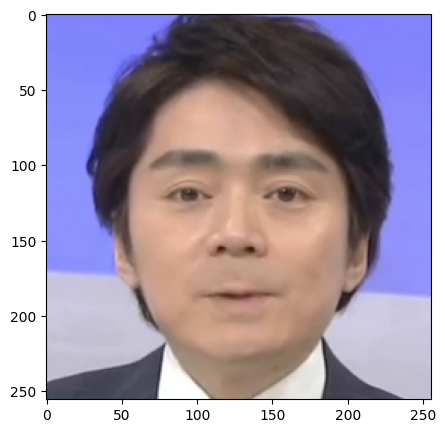

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(IMAGES_MOUTH_SYN[250])
plt.show()

### eye&mouth

In [66]:
IMAGES_EYE_MOUTH_SYN = []
for i in range(len(IMAGES)):
    if i == 0:
        IMAGES_EYE_MOUTH_SYN.append(IMAGES[0])
        continue
    monoMaskImage = cv2.split(mask_eye_mouth)[0] # reducing the mask to a monochrome
    br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
    center = (br[0] + br[2] // 2, br[1] + br[3] // 2)
    eye_mouth_syn = cv2.seamlessClone(IMAGES[i], IMAGES_EYE_MOUTH_LESS[0], mask_eye_mouth, center, cv2.NORMAL_CLONE)
    IMAGES_EYE_MOUTH_SYN.append(eye_mouth_syn)

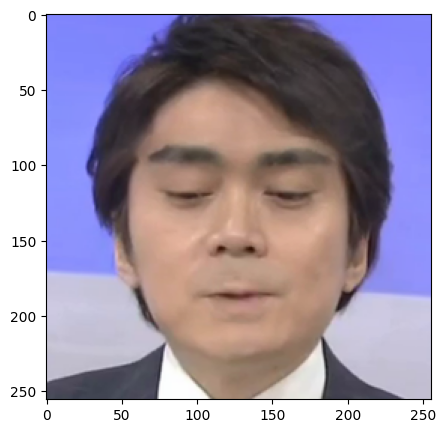

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(IMAGES_EYE_MOUTH_SYN[250])
plt.show()

## 保存

In [90]:
dst_dir = f"videos_test/video1/"

dst_dir_pose = f"{dst_dir}pose/"
if not os.path.exists(f"{dst_dir}pose/"):
    os.makedirs(f"{dst_dir}pose/")

dst_dir_crop = f"{dst_dir}crop/"
if not os.path.exists(f"{dst_dir_crop}eye/"):
    os.makedirs(f"{dst_dir_crop}eye/")
if not os.path.exists(f"{dst_dir_crop}mouth/"):
    os.makedirs(f"{dst_dir_crop}mouth/")
if not os.path.exists(f"{dst_dir_crop}eye_mouth/"):
    os.makedirs(f"{dst_dir_crop}eye_mouth/")

dst_dir_syn = f"{dst_dir}syn/"
if not os.path.exists(f"{dst_dir_syn}eye/"):
    os.makedirs(f"{dst_dir_syn}eye/")
if not os.path.exists(f"{dst_dir_syn}mouth/"):
    os.makedirs(f"{dst_dir_syn}mouth/")
if not os.path.exists(f"{dst_dir_syn}eye_mouth/"):
    os.makedirs(f"{dst_dir_syn}eye_mouth/")

### pose

In [91]:
for i in range(len(IMAGES)):
    cv2.imwrite(
        f"{dst_dir_pose}/{i+1:03}.png",
        cv2.cvtColor(IMAGES_ALL_LESS[i], cv2.COLOR_RGB2BGR),
    )

### eye

In [77]:
for i in range(len(IMAGES)):
    cv2.imwrite(
        f"{dst_dir_crop}/eye/{i+1:03}.png",
        cv2.cvtColor(IMAGES_EYE_CROP[i], cv2.COLOR_RGB2BGR),
    )
    cv2.imwrite(
        f"{dst_dir_syn}/eye/{i+1:03}.png",
        cv2.cvtColor(IMAGES_EYE_SYN[i], cv2.COLOR_RGB2BGR),
    )

### mouth

In [78]:
for i in range(len(IMAGES)):
    cv2.imwrite(
        f"{dst_dir_crop}/mouth/{i+1:03}.png",
        cv2.cvtColor(IMAGES_MOUTH_CROP[i], cv2.COLOR_RGB2BGR),
    )
    cv2.imwrite(
        f"{dst_dir_syn}/mouth/{i+1:03}.png",
        cv2.cvtColor(IMAGES_MOUTH_SYN[i], cv2.COLOR_RGB2BGR),
    )

### eye&mouth

In [79]:
for i in range(len(IMAGES)):
    cv2.imwrite(
        f"{dst_dir_crop}/eye_mouth/{i+1:03}.png",
        cv2.cvtColor(IMAGES_EYE_MOUTH_CROP[i], cv2.COLOR_RGB2BGR),
    )
    cv2.imwrite(
        f"{dst_dir_syn}/eye_mouth/{i+1:03}.png",
        cv2.cvtColor(IMAGES_EYE_MOUTH_SYN[i], cv2.COLOR_RGB2BGR),
    )

In [62]:
if not os.path.exists(f"videos_test/video1/pose_nose/"):
    os.makedirs(f"videos_test/video1/pose_nose/")
for i in range(len(IMAGES)):
    cv2.imwrite(
        f"videos_test/video1/pose_nose/{i+1:03}.png",
        cv2.cvtColor(IMAGES_EYE_MOUTH_LESS[i], cv2.COLOR_RGB2BGR),
    )